In [1]:
#mount
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
#pip installations
!pip install --quiet SimpleITK
!pip install --quiet seaborn
!pip install --quiet livelossplot
#!pip install --quiet torch == 1.9 #may not need
!pip install --quiet ctviewer
!pip install --quiet monai

     |████████████████████████████████| 52.8 MB 240 kB/s 
     |████████████████████████████████| 1.6 MB 41.2 MB/s 
     |████████████████████████████████| 1.1 MB 28.2 MB/s 


In [3]:
#copy from github
!git clone https://github.com/kilgore92/PyTorch-UNet.git
%cd PyTorch-UNet
%cd src
from unet.model import UNet
%cd ..
%cd ..

#imports
#import monai
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
import seaborn as sns
import pandas as pd
pd.options.mode.chained_assignment = None
import torch
import os
import sklearn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from livelossplot import PlotLosses
import torch.nn as nn
import json
import datetime
from datetime import datetime
from sklearn.metrics import confusion_matrix
import torchvision
import random
from ctviewer import CTViewer

#set the Dice Loss for model learning
import monai
import numpy as np
import os

#Dice Loss used for criterion
import torch
import torch.nn as nn
import torch.functional as f
import numpy as np


#device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

Cloning into 'PyTorch-UNet'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 213 (delta 21), reused 37 (delta 12), pack-reused 165
Receiving objects: 100% (213/213), 43.46 KiB | 14.49 MiB/s, done.
Resolving deltas: 100% (94/94), done.
/content/PyTorch-UNet
/content/PyTorch-UNet/src
/content/PyTorch-UNet
/content
cuda


In [4]:
#Dataset
class CustomImageDataset(Dataset):
    def __init__(self, df, cta_label, gt_label, aug = False, binarize = False):
        self.df = df
        self.len = len(df)
        self.aug = aug
        self.cta_label = cta_label
        self.gt_label = gt_label
        self.binarize = binarize

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
      row = self.df.iloc[idx]
      image = sitk.GetArrayFromImage(sitk.ReadImage(row[self.cta_label]))
      label = sitk.GetArrayFromImage(sitk.ReadImage(row[self.gt_label]))
      image = np.expand_dims(image, axis = (0))
      label = np.expand_dims(label, axis = (0))
      image = torch.Tensor(image)
      label = torch.Tensor(label)

      #binarize for the firt stage (could have implemented for the previous models, AAA-DICOM)
      if self.binarize:
        label = torch.where(label >= 1, 1, 0)

      #augmentation
      if self.aug:
        if random.random() > 0.5:
          #horizontal
          image = torchvision.transforms.functional.hflip(image)
          label = torchvision.transforms.functional.hflip(label)
        if random.random() > 0.5:
          #vertical
          image = torchvision.transforms.functional.vflip(image)
          label = torchvision.transforms.functional.vflip(label)
        if random.random() > 0.5:
          #rotate
          angle = random.choice([30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330])
          image = torchvision.transforms.functional.rotate(image, angle)
          label = torchvision.transforms.functional.rotate(label, angle)
        #noise
        if random.random() > 0.5:
          noise = torch.normal(random.uniform(-0.9, 0.9), random.uniform(0.01, 0.1), image.shape)
          image = image + noise
        #alternate rotations about the axis
        if random.random() > 0.25:
          ls = random.sample([1,2,3], 2)
          k = random.randint(1, 3)
          image = torch.rot90(image, k, ls)
          label = torch.rot90(label, k, ls)

      #return
      return image, label

#get the optimizer and scheduler
def get_opt_sch(model, train_params):
  #AdamW
  if train_params['optimizer'] == 'AdamW':
    #optimizer 
    optimizer = torch.optim.AdamW(model.parameters(), lr = train_params['lr'], weight_decay = train_params['weight_decay'])

  #Adam
  if train_params['optimizer'] == 'Adam':
    #optimizer 
    optimizer = torch.optim.Adam(model.parameters(), lr = train_params['lr'], weight_decay = train_params['weight_decay'])

  #NAdam
  if train_params['optimizer'] == 'NAdam':
    #optimizer 
    optimizer = torch.optim.NAdam(model.parameters(), lr = train_params['lr'], weight_decay = train_params['weight_decay'])

  #RAdam
  if train_params['optimizer'] == 'RAdam':
    #optimizer 
    optimizer = torch.optim.RAdam(model.parameters(), lr = train_params['lr'], weight_decay = train_params['weight_decay'])

  #scheduler (intutively modify the learning rate)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       mode = 'min', 
                                                       factor = train_params['factor'], 
                                                       patience = train_params['patience'], 
                                                       threshold = train_params['threshold'], 
                                                       threshold_mode = 'rel', 
                                                       cooldown = 0, 
                                                       min_lr = 0, 
                                                       eps = 1, 
                                                       verbose = True)
  
  #return
  return optimizer, scheduler

class DICELoss(nn.Module):
      def __init__(self, weight=None, size_average=True):
          super(DICELoss, self).__init__()

      def forward(self, output, mask, eps=1e-8):
          """
          The output layer of Kilgore's 3D-UNet implementation is a LeakyReLU.
          We need to apply a sigmoid activation to the model output in order to
          constrain the target value between 0 and 1.
          See source code (Line 243):
          https://github.com/kilgore92/PyTorch-UNet/blob/master/src/unet/blocks.py#L243
          """

          output = torch.sigmoid(output)
          
          output = output.view(-1)
          mask = mask.view(-1)
          
          intersection = (output * mask).sum()                            
          dice_coeff = (2.*intersection + eps)/(output.sum() + mask.sum() + eps)  

          dice_loss = 1 - dice_coeff

          return dice_loss

#loss func
def get_loss_func(train_params):
  #generalized dice loss
  if train_params['loss'] == 'GDL':
    loss = monai.losses.GeneralizedDiceLoss(include_background = True, softmax = True, to_onehot_y = True)
  #masked dice loss - the contribution is specific to the mask! could try variant with softmax binary class activation
  if train_params['loss'] == 'MDL':
    loss = monai.losses.MaskedDiceLoss(include_background = False, sigmoid = True)
  #all of the above
  if train_params['loss'] == 'MDL':
    loss = monai.losses.GeneralizedDiceFocalLoss(include_background = True, softmax = True, to_onehot_y = True, focal_weight = [0.01, 0.65, 0.24, 0.1])
  if train_params['loss'] == 'DiceLoss':
    loss = DICELoss()
  #return
  return loss

#save json file
def save_params(hyper_params, save_path):
  json_string = json.dumps(hyper_params)
  with open(save_path, 'w') as outfile:
    outfile.write(json_string)

#load the train params back in
def load_params(fpath):
  # Opening JSON file
  with open(fpath) as json_file:
    data = json.load(json_file)
  return data

#load a pretrained model
def load_pretrained_model(save_folder, device):
  train_params = load_params(save_folder + 'train_params.json')
  model = torch.load(train_params['save_path'] + 'model.pth')
  model.to(device)
  return train_params, model

#save image
def save_image(save_path, save_folder, patient, image):
  #save file
  if os.path.isdir(save_path + save_folder) == False:
    os.mkdir(save_path + save_folder)
  #save file
  save_loc = save_path + save_folder + '/' + patient + '.nii.gz'
  #write
  sitk.WriteImage(image, save_loc)
  #return
  return save_loc

#localized prediction inference
def localized_predictions_inference(row, train_params, model, resampler, otsu, device):
  #read in the CTA-64 model
  orig_image = sitk.ReadImage(row['Norm-CTA'])
  image = sitk.ReadImage(row['Norm-CTA-64'])
  #already normalized
  x = torch.Tensor(np.expand_dims(sitk.GetArrayFromImage(image), axis = (0, 1))).to(device)
  #pass
  model.eval()
  with torch.no_grad():
    y_pred = model(x)
    #save space?
    x = None
  #convert back
  prediction = sitk.GetImageFromArray(np.squeeze(torch.sigmoid(y_pred).cpu().detach().numpy()))
  #save space?
  y_pred = None
  #reset to the og
  prediction.CopyInformation(image)
  #upsample to the original
  resampler.SetReferenceImage(orig_image)
  resampler.SetTransform(sitk.Transform())
  #resampler.SetInterpolator(sitk.sitkNearestNeighbor)
  resampler.SetInterpolator(sitk.sitkBSpline)
  prediction = resampler.Execute(prediction)
  prediction.CopyInformation(orig_image)
  #otsu threshold
  otsu.SetOutsideValue(1)
  otsu.SetInsideValue(0)
  prediction = otsu.Execute(prediction)

  #save info somewhere
  return save_image(train_params['save_path'], 'localized-predictions', row['Patient'], prediction)

#image resampling
def resample_image_standardize(itk_image, out_size = (64,64,64), is_label = False):
  original_spacing = itk_image.GetSpacing()
  original_size = itk_image.GetSize()
  out_spacing = [original_size[0] * (original_spacing[0] / out_size[0]),
                 original_size[1] * (original_spacing[1] / out_size[1]),
                 original_size[2] * (original_spacing[2] / out_size[2])]

  resample = sitk.ResampleImageFilter()
  resample.SetOutputSpacing(out_spacing)
  resample.SetOutputOrigin(itk_image.GetOrigin())
  resample.SetSize(out_size)
  resample.SetOutputDirection(itk_image.GetDirection())
  resample.SetTransform(sitk.Transform())
  #resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
  if is_label:
      resample.SetInterpolator(sitk.sitkNearestNeighbor)
  else:
      resample.SetInterpolator(sitk.sitkBSpline)
  return resample.Execute(itk_image)

#generate a binary mask
def binarize(lower, upper, image, binary_filter):
  binary_filter.SetLowerThreshold(lower)
  binary_filter.SetUpperThreshold(upper)
  return binary_filter.Execute(image)

#high res segmentation
def high_res_predictions_inference(row, train_params, model, resampler, otsu, device):
  #read in the CTA-64
  orig_image = sitk.ReadImage(row['Norm-CTA'])
  localized_prediction = sitk.ReadImage(row['localized-predictions'])
  #apply #the bounding box to the CTA
  #filter
  label_shape_filter = sitk.LabelShapeStatisticsImageFilter()
  #apply
  label_shape_filter.Execute(localized_prediction)
  #get bbox
  bbox = label_shape_filter.GetBoundingBox(1) #in pixel coordinates
  #get ROI
  ROI_image = sitk.RegionOfInterest(orig_image, bbox[int(len(bbox)/2):], bbox[0:int(len(bbox)/2)])
  #resample the CTA
  ROI_image_64 = resample_image_standardize(ROI_image, out_size = (64, 64, 64), is_label = False)
  #z-norm the CTA
  z = sitk.NormalizeImageFilter()
  ROI_image_64 = z.Execute(ROI_image_64)
  #pass
  x = torch.Tensor(np.expand_dims(sitk.GetArrayFromImage(ROI_image_64), axis = (0, 1))).to(device)
  #pass
  model.eval()
  with torch.no_grad():
    y_pred = model(x)
    #save space?
    x = None
  #convert back
  prediction = sitk.GetImageFromArray(np.squeeze(torch.sigmoid(y_pred).cpu().detach().numpy()))
  #save space?
  y_pred = None
  #reset to the og
  prediction.CopyInformation(ROI_image_64)
  #upsample to the original
  resampler.SetReferenceImage(ROI_image)
  resampler.SetTransform(sitk.Transform())
  #resampler.SetInterpolator(sitk.sitkNearestNeighbor)
  resampler.SetInterpolator(sitk.sitkBSpline)
  prediction = resampler.Execute(prediction)
  prediction.CopyInformation(ROI_image)
  #perform otsu thresholding here
  otsu.SetOutsideValue(1)
  otsu.SetInsideValue(0)
  prediction = otsu.Execute(prediction)
  #insert back into the original frame of reference
  blank_image = sitk.Image(orig_image.GetSize(), sitk.sitkUInt8)
  #insert the high resolution segmentation into the original CTA
  pred_origin = orig_image.TransformPhysicalPointToContinuousIndex(prediction.GetOrigin())
  #bounds
  pred_bounds = prediction.GetSize()
  #insert
  try:
    blank_image[
        int(pred_origin[0]):int(pred_origin[0] + pred_bounds[0]), 
        int(pred_origin[1]):int(pred_origin[1] + pred_bounds[1]), 
        int(pred_origin[2]):int(pred_origin[2] + pred_bounds[2])
        ] = prediction
  except:
    #safeguard (use try and except and else)
    blank_image[
        int(pred_origin[0]):(int(pred_origin[0]) + int(pred_bounds[0])),
        int(pred_origin[1]):(int(pred_origin[1]) + int(pred_bounds[1])),
        int(pred_origin[2]):(int(pred_origin[2]) + int(pred_bounds[2]))
        ] = prediction
  #copy
  blank_image.CopyInformation(orig_image)
  #smooth = sitk.BinaryMedianImageFilter()
  #smooth.GetBackgroundValue(0)
  #smooth.GetForegroundValue(1)
  #smooth.SetBackgroundValue(0)
  #smooth.SetForegroundValue(1)
  #save
  return save_image(train_params['save_path'], 'high-res-predictions', row['Patient'], blank_image)

#perform DSC score evaluation
def compute_metrics(gt, pred, metrics = sitk.LabelOverlapMeasuresImageFilter()):
  #compare
  metrics.Execute(gt, pred)
  DSC = metrics.GetDiceCoefficient()
  FP = metrics.GetFalsePositiveError()
  FN = metrics.GetFalseNegativeError()
  JC = metrics.GetJaccardCoefficient()
  #gt
  #pred
  return DSC, FP, FN, JC

#visualize one specific image (cannot superimpose mask as of yet)
def visualize_specific_image(row, im_type):
  image = sitk.GetArrayFromImage(sitk.ReadImage(row[im_type]))
  CTViewer(image)
  plt.show()

#parameters for visualizing the bounding box in Paraview; unable to print out the 
def visualize_paraview(row):
  z = sitk.NormalizeImageFilter()
  #modify the localized prediction information to reconcile with the original CTA (only required for visualization purposes; 
  #otherwise preserve for reinsertion of bounding box into original frame of reference)
  #Paraview
  #properties
  #coloring
  #line width
  #convert and extract for visualization purposes
  #read prediction
  bbox_prediction = sitk.ReadImage(row['localized-predictions'])
  bbox_high_prediction = sitk.ReadImage(row['high-res-predictions'])
  #read original CTA
  CTA = sitk.ReadImage(row['Norm-CTA'])
  #extract
  label_shape_filter = sitk.LabelShapeStatisticsImageFilter()
  #apply
  label_shape_filter.Execute(bbox_prediction)
  #get bbox
  bbox = label_shape_filter.GetBoundingBox(1) #in pixel coordinates
  #get ROI
  ROI_CTA = sitk.RegionOfInterest(CTA, bbox[int(len(bbox)/2):], bbox[0:int(len(bbox)/2)])
  ROI_CTA = z.Execute(ROI_CTA)
  ROI_prediction = sitk.RegionOfInterest(bbox_prediction, bbox[int(len(bbox)/2):], bbox[0:int(len(bbox)/2)])
  ROI_high_prediction = sitk.RegionOfInterest(bbox_high_prediction, bbox[int(len(bbox)/2):], bbox[0:int(len(bbox)/2)])
  #register for visual only
  #ROI_CTA.SetOrigin(CTA.GetOrigin())
  #ROI_prediction.SetOrigin(CTA.GetOrigin())
  #filter_extractsubset = CTA.TransformPhysicalPointToContinuousIndex(ROI_prediction.GetOrigin()) #add this ROI_CTA.GetSize()
  #ROI_prediction.SetOrigin(ROI_prediction.TransformContinuousIndexToPhysicalPoint(filter_extractsubset))
  #ROI_prediction.SetOrigin(CTA.GetOrigin())
  #sitk.WriteImage(ROI_prediction, "/content/temp_origin.nii.gz")
  #ROI_prediction.SetOrigin(CTA.TransformContinuousIndexToPhysicalPoint(filter_extractsubset))
  #sitk.WriteImage(ROI_prediction, "/content/temp_origin231.nii.gz")
  #the origin in indexes relative to prediction
  min_coordinates = CTA.TransformPhysicalPointToIndex(ROI_CTA.GetOrigin())
  delta_coordinates = ROI_CTA.GetSize()
  max_coordinates = tuple(ele1 + ele2 for ele1, ele2 in zip(min_coordinates, delta_coordinates))
  print(row['Patient'])
  print('Bounding Box Visual')
  print('Min Coordinates:', min_coordinates)
  print('Max Coordinates: ', max_coordinates)
  print('Properties --> Solid Color --> Red --> LineWidth --> 5 --> Click Out of Properties to See Changes')
  #more visual
  if os.path.isdir(row['Patient']) == False:
    os.mkdir(row['Patient'])
  sitk.WriteImage(ROI_CTA, row['Patient'] + '/ROI-CTA.nii.gz')
  sitk.WriteImage(ROI_prediction, row['Patient'] + '/ROI-Low-Prediction.nii.gz')
  sitk.WriteImage(ROI_high_prediction, row['Patient'] + '/ROI-High-Prediction.nii.gz')

#relabel for the purpose of graphing
def relabel(row, col, id, l1, l2):
  if row[col] == id:
    return l1
  else:
    return l2

#relabel for the purpose of graphing
def relabel2(row, col, id, l1):
  if row[col] == id:
    return l1
  else:
    return row[col]

#plot
def plot_results(train_params, x, y, df, hue, kind = 'box', color = 'Greys', xlabel = None, ylabel = None, yticks = [0, 0.2, 0.4, 0.6, 0.8, 1], sns_legend = False, legend = False, fsize = 15, save_name = None):
  if xlabel == None:
    xlabel = x
  if ylabel == None:
    ylabel = y
  if save_name == None:
    save_name = x + '_' + y + '.png'
  #plot
  #sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})
  ax = sns.catplot(x = x, y = y, data = df, hue = hue, kind = kind, palette = sns.color_palette(color, 2), legend = sns_legend)
  plt.yticks(yticks, fontsize = fsize, fontname='Times New Roman')
  plt.ylabel(ylabel, fontsize = fsize, fontname='Times New Roman')
  plt.xticks(fontsize = fsize, fontname='Times New Roman')
  plt.xlabel(xlabel, fontsize = fsize, fontname='Times New Roman')
  if legend == True:
    plt.legend(title = 'Dataset', fontsize = fsize, title_fontsize = fsize, loc='center left', bbox_to_anchor=(1, 0.5))

  plt.savefig(train_params['save_path'] + save_name, bbox_inches="tight")
  plt.show()

#get breakdown off results
def see_results(train_params, name, df, groups, metrics):
  df_temp = df.groupby(groups)[metrics].describe().round(2)
  df_temp.to_csv(train_params['save_path'] + name)
  display(df_temp)


In [5]:
#read in the saved pickle file
data_path = '/content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-Wall/data/3D/data_split.pkl'
df = pd.read_pickle(data_path)

In [ ]:
#first part is the localizer

#save folder
save_folder = '/content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-Wall/results/class-Symp-BB-AAA-Wall-UNet-results/'
#specify a save location
folder = datetime.now().strftime("localizer-%Y-%m-%d-%H-%M") + '/'
#the save path for everything
save_path = save_folder + folder
if os.path.isdir(save_path) == False:
  os.mkdir(save_path)

In [ ]:
#specify the model params
model_params = {}

#specify the type of model and its correspnding parameters
model_params = {
    'type': 'OG_Unet' #modify this to change the type and the later entries to change parameter settings
}

#aux params (classification)?
#aux_params = {
#    'classes': None,
#    'pooling': 'avg',
#    'dropout': 0,
#    'activation': None
#    }

#og_unet
if model_params['type'] == 'OG_Unet':
  model_params['n_channels'] = 1
  model_params['base_filter_num'] = 64
  model_params['num_blocks'] = 4
  model_params['num_classes'] = 1
  model_params['mode'] = '3D'
  model_params['dropout'] = False
  model_params['dropout_rate'] = 0.2
  model_params['use_pooling'] = True #dpes this make differnece?
  #define the model
  model = UNet(model_params['n_channels'], model_params['base_filter_num'], model_params['num_blocks'], model_params['num_classes'], model_params['mode'], model_params['dropout'],
               model_params['dropout_rate'], model_params['use_pooling'])

In [ ]:
#init
train_params = {}
#training parameters
train_params = {
    'batch_size': 1, #try to keep high as possible/increases stability
    'lr': 1e-4, #could try 1e-3 or 1e-5 ?
    'optimizer': 'AdamW',
    'weight_decay': 1e-2, #decrease this?
    'factor': 1e-1,
    'patience': 2, #1
    'threshold': 1e-3, #might need to increase this
    'epochs': 50,
    'loss': 'DiceLoss', 
    'model_params': model_params,
    'aug': True,
    'save_path': save_path, 
    'epochs_trained': 0,
    'model_type': 'localizer',
    'data': data_path
}

In [ ]:
#obtain the training data
dset_train = CustomImageDataset(df[(df['DATA'] == 'TRAIN') & (df['Class'] == 'Symptomatic')], cta_label = 'Norm-CTA-64', gt_label = 'Mask-All-64', 
                                aug = train_params['aug'], binarize = True)
train_loader = DataLoader(dset_train, batch_size = train_params['batch_size'])
#obtain the validation data (or test in this case)
dset_test = CustomImageDataset(df[df['DATA'] == 'TEST'], cta_label = 'Norm-CTA-64', gt_label = 'Mask-All-64', #there is mask-wall-64 now
                               aug = False, binarize = True)
test_loader = DataLoader(dset_test, batch_size = train_params['batch_size'])
#send to device
model.to(device)
#get the optimizer and scheduler
optimizer, scheduler = get_opt_sch(model, train_params)
#get the loss
criterion = DICELoss()

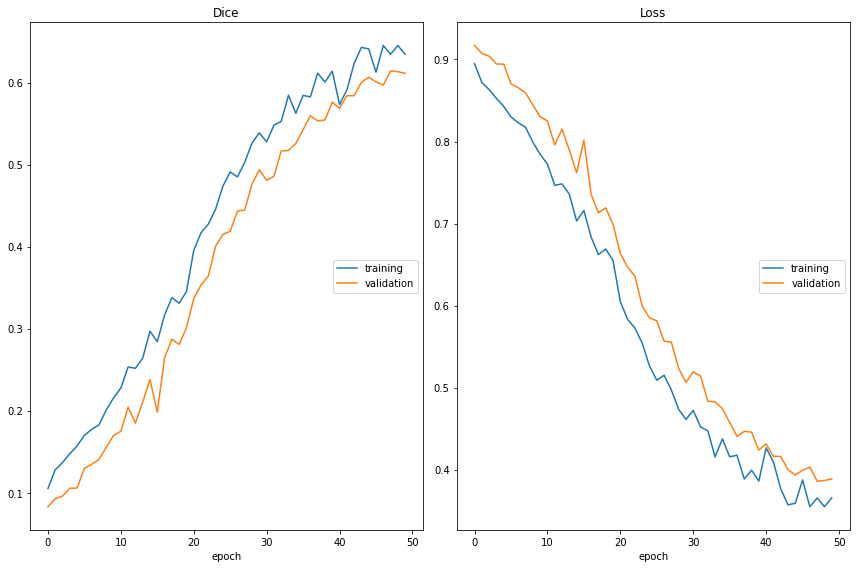

Dice
	training         	 (min:    0.105, max:    0.645, cur:    0.634)
	validation       	 (min:    0.083, max:    0.614, cur:    0.611)
Loss
	training         	 (min:    0.355, max:    0.895, cur:    0.366)
	validation       	 (min:    0.386, max:    0.917, cur:    0.389)
CPU times: user 1h 46min 33s, sys: 1min 21s, total: 1h 47min 54s
Wall time: 1h 57min 7s


In [ ]:
%%time
#plotting in Jupyter Notebook 11 min for firts epoch 
liveloss = PlotLosses()
#logs
logs = {}
#iterate epochs
for epoch in range(train_params['epochs_trained'] + 1, train_params['epochs'] + 1):
  #determine losses
  train_epoch_loss = 0
  val_epoch_loss = 0
  #specify training
  model.train()
  #iterate through the training data
  for i, (x, y_true) in enumerate(train_loader):
    #zero optimizers
    optimizer.zero_grad()
    #send to GPU
    x = x.to(device)
    y_true = y_true.to(device)
    #predict
    y_pred = model(x)
    #determine loss (should already be averaged)
    loss = criterion(y_pred, y_true)
    #backward
    loss.backward()
    #step
    optimizer.step()
    #track the loss
    train_epoch_loss = train_epoch_loss + loss.item() #/ train_params['batch_size']
    #break
    #if i > 1:
      #break
  #specify eval
  model.eval()
  #set
  with torch.no_grad():
    #iterate through the testing data
    for i, (x, y_true) in enumerate(test_loader):
      #send to GPU
      x = x.to(device)
      y_true = y_true.to(device)
      #predict
      y_pred = model(x)
      #determine loss
      loss = criterion(y_pred, y_true)
      #track the loss (shoudld already be averaged)
      val_epoch_loss = val_epoch_loss + loss.item() #/ train_params['batch_size']
      #break
      #if i > 1:
        #break

  #specify the logs
  prefix = ''
  logs['Loss'] = train_epoch_loss / len(train_loader)
  logs['Dice'] = 1 - train_epoch_loss / len(train_loader)

  prefix = 'val_'
  logs[prefix + 'Loss'] = val_epoch_loss / len(test_loader)
  logs[prefix + 'Dice'] = 1- val_epoch_loss / len(test_loader)
  #living loss
  liveloss.update(logs)
  #send
  liveloss.send()
  #the scheduler (the way the loss is calculated must be correct for correct scheduling!)
  scheduler.step(train_epoch_loss)
  #save the model every 5 epochs 
  if (epoch % 5 == 0) and (epoch != 0):
    torch.save(model, train_params['save_path'] + 'model.pth')
    #keep track of training
    train_params['epochs_trained'] = 5 + train_params['epochs_trained']
    #save the number of epochs in case model stops training
    save_params(train_params, train_params['save_path'] + 'train_params.json')

In [6]:
#load the trained localizer model
model = None
train_params, model = load_pretrained_model('/content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-Wall/results/class-Symp-BB-AAA-Wall-UNet-results/localizer-2022-10-29-19-57/', device)

In [7]:
%%time
#init 15 min
resampler = sitk.ResampleImageFilter()
otsu = sitk.OtsuThresholdImageFilter()

#apply
df['localized-predictions'] = df.apply(localized_predictions_inference, axis = 1, args = (train_params, model, resampler, otsu, device))

CPU times: user 18min 5s, sys: 4.85 s, total: 18min 10s
Wall time: 13min 39s


In [8]:
#get merics
def get_metrics(row, gt_col = 'Mask-All', pred_col = 'localized-predictions', binary = sitk.BinaryThresholdImageFilter()):
  #read
  gt = sitk.ReadImage(row[gt_col])
  binary.SetUpperThreshold(3)
  binary.SetLowerThreshold(1)
  gt = binary.Execute(gt)
  pred = sitk.ReadImage(row[pred_col])
  return compute_metrics(gt, pred)

In [9]:
%%time
#apply
df['DSC'], df['FP'], df['FN'], df['JC'] = zip(*df.apply(get_metrics, axis = 1))
#save
df.to_pickle(train_params['save_path'] + 'df_results.pkl')
#save the params
save_params(train_params, train_params['save_path'] + 'train_params.json')

CPU times: user 49.5 s, sys: 1.16 s, total: 50.7 s
Wall time: 54.6 s


In [10]:
#apply df
df['Dataset'] = df.apply(relabel, axis = 1, args = ('DATA', 'TRAIN', 'Train', 'Test'))
df['Wall'] = df.apply(relabel2, axis = 1, args = ('Wall', 'NA', 'Asymptomatic'))

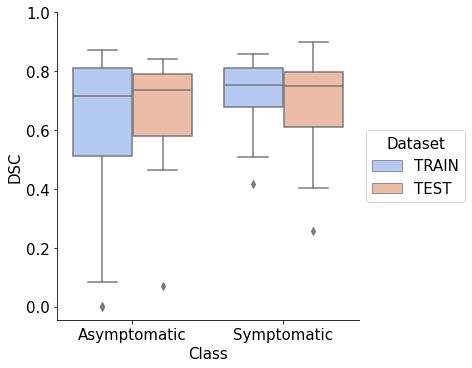

DSC                                          
                     count  mean   std   min   25%   50%   75%   max
Dataset Class                                                       
Test    Asymptomatic  25.0  0.67  0.17  0.07  0.58  0.74  0.79  0.84
        Symptomatic   25.0  0.69  0.16  0.26  0.61  0.75  0.80  0.90
Train   Asymptomatic  38.0  0.63  0.24  0.00  0.51  0.72  0.81  0.87
        Symptomatic   35.0  0.73  0.11  0.42  0.68  0.75  0.81  0.86

In [11]:
#do plotting
plot_results(train_params, x = 'Class', y = 'DSC', df = df, hue = 'DATA', color = 'coolwarm', legend = True)
#plot all the results
see_results(train_params, 'Dataset_Class_DSC.csv', df, groups = ['Dataset', 'Class'], metrics = ['DSC'])